In [ ]:
import skrf as rf
from skrf.media import DefinedGammaZ0
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, epsilon_0, mu_0, pi
from skrf.media import MLine


# 真空の特性インピーダンス (約 377 Ω)
eta_0 = np.sqrt(mu_0 / epsilon_0)
freq = rf.Frequency(start=8, stop=18, npoints=101, unit='ghz')


# dimentsions and material
D = 2e-3      # 周期 (2 mm) 
w = 0.2e-3    # ギャップ幅 (0.2 mm) 
d_sub = 1e-3  # 基板厚 (1 mm) 
eps_r = 10.2  # 基板の比誘電率

theta_deg_list = [0, 65, 85]



k0 = 2 * pi * freq.f / c
eps_eff = (eps_r +1 )  / 2

k_eff = k0 * np.sqrt (eps_eff)

eta_eff = eta_0 / np.sqrt(eps_eff)

alpha = (k_eff * D / pi) * np.log(1 / np.sin(pi * w / (2 * D)))


print(f"--- 8 GHz (計算開始点) での値 ---")
print(f"k0 (1/m): {k0[0]:.2f}")
print(f"有効誘電率 (eps_eff): {eps_eff:.2f}")
print(f"有効波数 (k_eff, 1/m): {k_eff[0]:.2f}")
print(f"有効インピーダンス (eta_eff, Ω): {eta_eff:.2f}")
print(f"グリッドパラメータ (alpha): {alpha[0]:.4f}")

print(f"\n--- 18 GHz (計算終了点) での値 ---")
print(f"k0 (1/m): {k0[-1]:.2f}")
print(f"グリッドパラメータ (alpha): {alpha[-1]:.4f}")

--- 8 GHz (計算開始点) での値 ---
k0 (1/m): 167.67
有効誘電率 (eps_eff): 5.60
有効波数 (k_eff, 1/m): 396.77
有効インピーダンス (eta_eff, Ω): 159.20
グリッドパラメータ (alpha): 0.4686

--- 18 GHz (計算終了点) での値 ---
k0 (1/m): 377.25
グリッドパラメータ (alpha): 1.0543


In [35]:
# Zg
j = 1j

def calculate_zg_patch(k0, k_eff, eta_eff, alpha, theta_rad, polarization):

    if polarization.upper() == 'TM':
        # formula(8)
        Zg_tm = -j * eta_eff / (2 * alpha)
        return Zg_tm
    
    elif polarization.upper() == 'TE':
        # formula(9)
        k_ratio_sq = (k0 / k_eff)**2
        denominator = 1 - (k_ratio_sq * (np.sin(theta_rad)**2) / 2)
        Zg_te = -j * eta_eff / (2 * alpha * denominator)
        return Zg_te
    
    else:
        raise ValueError("Polarization must be 'TE' or 'TM'")

def calculate_zg_strip(k0, k_eff, eta_eff, alpha, theta_rad, polarization):
    """
    ストリップアレイ (Fig. 2(b)) のグリッドインピーダンス Zg' を計算する
    """
    if polarization.upper() == 'TM':
        # 式 (10)
        Zg_tm = -j * eta_eff / (2 * alpha)
        return Zg_tm
    
    elif polarization.upper() == 'TE':
        # 式 (11)
        k_ratio_sq = (k0 / k_eff)**2
        denominator = 1 - (k_ratio_sq * np.sin(theta_rad)**2)
        Zg_te = -j * eta_eff / (2 * alpha * denominator)
        return Zg_te
    
    else:
        raise ValueError("Polarization must be 'TE' or 'TM'")

In [40]:
#Z0

def calculate_z0(eta_0,theta_rad, polarization):

    if polarization.upper() == 'TE':
        Z0_port_te = eta_0 / np.cos(theta_rad) 
        return Z0_port_te
    elif polarization.upper() == 'TM':
        Z0_port_tm = eta_0 * np.cos(theta_rad)
        return Z0_port_tm
    else:
        raise ValueError("Polarization must be 'TE' or 'TM'")

In [37]:
#Zs

def calculate_zs(d_sub, eps_r, theta_rad, polarization):
    k_slab = k0 * np.sqrt(eps_r)
    beta = k0 * np.sqrt(eps_r - np.sin(theta_rad)**2)
    # 基板の特性インピーダンス (Z_slab)
    if polarization.upper() == 'TE':
        # Z_slab_TE = w*mu / beta
        Z_slab_te = (freq.w * mu_0) / beta
        Zs_te = j * Z_slab_te * np.tan(beta * d_sub)
        return Zs_te
    elif polarization.upper() == 'TM':
        # Z_slab_TM = beta / (w*epsilon)
        Z_slab_tm = beta / (freq.w * epsilon_0 * eps_r)
        Zs_tm = j * Z_slab_tm * np.tan(beta * d_sub)
        return Zs_tm
        

In [ ]:
# Reflection Phase Gamma
def calculate_reflection_phase(theta_deg, polarization):
    theta_rad = np.deg2rad(theta_deg)
    
    # 各インピーダンスの計算
    Zg = calculate_zg_patch(k0, k_eff, eta_eff, alpha, theta_rad, polarization)
    Z0_port = calculate_z0(eta_0, theta_rad, polarization)
    Zs = calculate_zs(d_sub, eps_r, theta_rad, polarization)
    
    # 入力インピーダンス
    Zinp = 1 / (1/Zs + 1/Zg)
    
    # 反射係数
    Gamma = (Zinp - Z0_port) / (Zinp + Z0_port)
    
    # 位相（度）
    phase_deg = np.angle(Gamma) * 180 / pi
    
    return phase_deg

保存完了: reflection_phase_TE.png


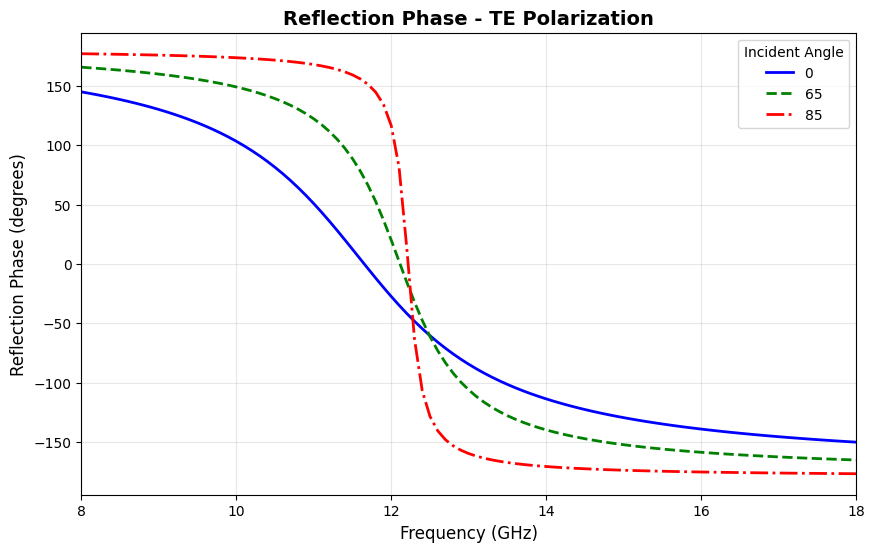

保存完了: reflection_phase_TM.png


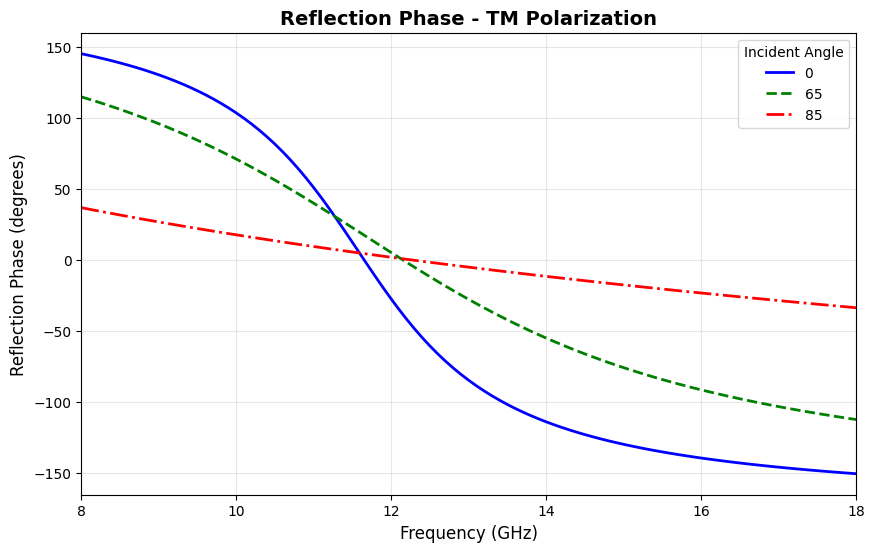


--- 解析完了 ---

TE 偏波:
  0° @ 13 GHz: -84.63°
  65° @ 13 GHz: -106.26°
  85° @ 13 GHz: -159.88°

TM 偏波:
  0° @ 13 GHz: -84.63°
  65° @ 13 GHz: -27.76°
  85° @ 13 GHz: -5.09°


In [ ]:
# 各偏波・入射角での計算とプロット
polarizations = ['TE', 'TM']
colors = ['b', 'g', 'r']  # 0°, 65°, 85° 用
linestyles = ['-', '--', '-.']

for pol in polarizations:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, theta_deg in enumerate(theta_deg_list):
        phase = calculate_reflection_phase(theta_deg, pol)
        ax.plot(freq.f / 1e9, phase, 
                color=colors[i], 
                linestyle=linestyles[i],
                linewidth=2, 
                label=f'{theta_deg}')
    
    ax.set_xlabel('Frequency (GHz)', fontsize=12)
    ax.set_ylabel('Reflection Phase (degrees)', fontsize=12)
    ax.set_title(f'Reflection Phase - {pol} Polarization', fontsize=14, fontweight='bold')
    ax.legend(title='Incident Angle', fontsize=10)
    ax.grid(True, alpha=0.3)  
    ax.set_xlim(8, 18)
    
    # ファイル保存
    filename = f'reflection_phase_{pol}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"保存完了: {filename}")
    
    plt.show()

# 結果サマリー出力
print("\n--- 解析完了 ---")
for pol in polarizations:
    print(f"\n{pol} 偏波:")
    for theta_deg in theta_deg_list:
        phase = calculate_reflection_phase(theta_deg, pol)
        mid_idx = len(freq.f) // 2
        print(f"  {theta_deg}° @ 13 GHz: {phase[mid_idx]:.2f}°")